In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()

Num GPUs Available: 1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/oilspill_dataset/"
IMG_SIZE = (256, 256)
BATCH_SIZE = 4

print("TF version:", tf.__version__)


Mounted at /content/drive
TF version: 2.19.0


In [ ]:
def get_paths(split):
    img_dir  = os.path.join(ROOT, split, "resized_images")
    mask_dir = os.path.join(ROOT, split, "resized_masks")

    img_paths, mask_paths = [], []
    for fname in sorted(os.listdir(img_dir)):
        fname_low = fname.lower()
        if fname_low.endswith(".jpg") or fname_low.endswith(".jpeg") or fname_low.endswith(".png"):
            img_paths.append(os.path.join(img_dir, fname))
            mask_name = os.path.splitext(fname)[0] + ".png"  # masks are PNG
            mask_paths.append(os.path.join(mask_dir, mask_name))
    return img_paths, mask_paths

train_imgs, train_masks = get_paths("train")
val_imgs,   val_masks   = get_paths("val")

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))
print("Example image:", train_imgs[0])
print("Example mask:", train_masks[0])


Train images: 811
Val images: 203
Example image: /content/drive/MyDrive/oilspill_dataset/train/resized_images/Oil (1).jpg
Example mask: /content/drive/MyDrive/oilspill_dataset/train/resized_masks/Oil (1).png


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)            # 3-channel RGB
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0                 # NORMALIZATION 0–1
    return img

def load_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_png(m, channels=1)                 # 1-channel mask
    m = tf.image.resize(m, IMG_SIZE, method='nearest')
    m = tf.cast(m, tf.float32) / 255.0                     # 0 or 1
    return m

def load_pair(img_path, mask_path):
    img  = load_image(img_path)
    mask = load_mask(mask_path)
    return img, mask


In [ ]:
def augment(img, mask):
    # horizontal flip
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    # vertical flip
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    # small random brightness change
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, mask


In [ ]:
def make_dataset(img_paths, mask_paths, training=True):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.shuffle(buffer_size=len(img_paths)) if training else ds
    ds = ds.map(lambda x,y: load_pair(x,y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_imgs, train_masks, training=True)
val_ds   = make_dataset(val_imgs,   val_masks,   training=False)

train_ds, val_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

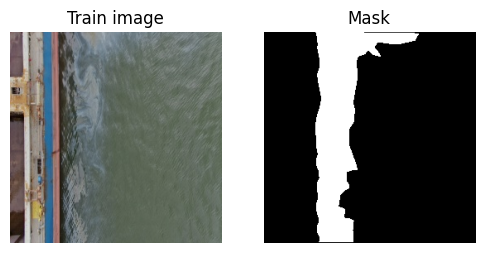

In [ ]:
imgs, masks = next(iter(train_ds))

plt.figure(figsize=(6,3))

# Display image (clip values between 0 and 1)
plt.subplot(1,2,1)
plt.imshow(tf.clip_by_value(imgs[0], 0, 1))
plt.title("Train image")
plt.axis("off")

# Display mask
plt.subplot(1,2,2)
plt.imshow(masks[0].numpy().squeeze(), cmap='gray')
plt.title("Mask")
plt.axis("off")

plt.show()


In [ ]:
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(256,256,3)):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    bn = conv_block(p4, 512)

    d1 = decoder_block(bn, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    model = models.Model(inputs, outputs, name="U_Net_OilSpill")
    return model

model = build_unet()
model.summary()


Model: "U_Net_OilSpill"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# Dice coefficient & loss
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

# IoU metric
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_pred_f = tf.cast(y_pred_f > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

metrics = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    dice_coef,
    iou_metric
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=metrics
)


In [ ]:
checkpoint_path = "/content/drive/MyDrive/oilspill_results/best_unet.keras"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_accuracy",
        save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, mode="max",
        restore_best_weights=True, verbose=1)
]

EPOCHS = 25  # you can stop earlier if it's already good

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7216 - dice_coef: 0.5281 - iou_metric: 0.4880 - loss: 1.0225 - precision: 0.5505 - recall: 0.8107   
Epoch 1: val_accuracy improved from -inf to 0.65793, saving model to /content/drive/MyDrive/oilspill_results/best_unet.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.7219 - dice_coef: 0.5283 - iou_metric: 0.4883 - loss: 1.0220 - precision: 0.5509 - recall: 0.8108 - val_accuracy: 0.6579 - val_dice_coef: 0.4047 - val_iou_metric: 0.4123 - val_loss: 1.2404 - val_precision: 0.5137 - val_recall: 0.7801
Epoch 2/25
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8264 - dice_coef: 0.6469 - iou_metric: 0.6082 - loss: 0.7630 - precision: 0.6817 - recall: 0.8610
Epoch 2: val_accuracy improved from 0.65793 to 0.74874, saving model to /content/drive/MyDrive/oilspill_results/best_unet.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.8264 - dice_coef: 0.6469 - iou_metric: 0.6082 - loss: 0.7629 - preci

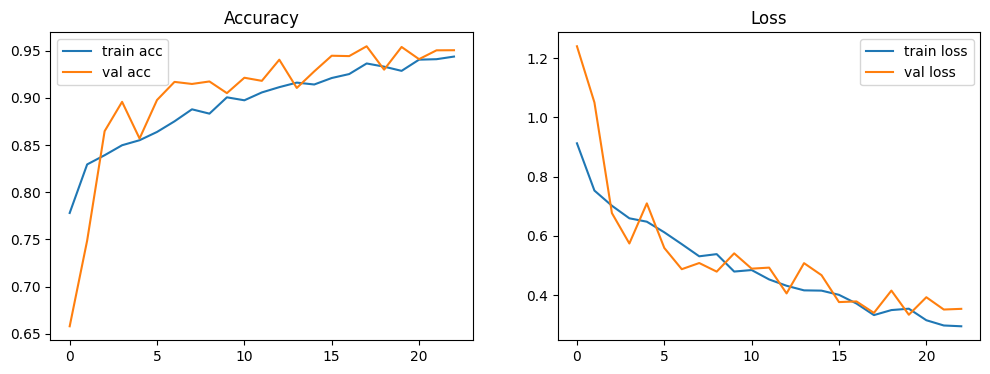

In [ ]:
hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist["accuracy"], label="train acc")
plt.plot(hist["val_accuracy"], label="val acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.legend(); plt.title("Loss")
plt.show()


In [ ]:
results = model.evaluate(val_ds)
print("Metric names:", model.metrics_names)
print("Values:", results)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9351 - dice_coef: 0.7358 - iou_metric: 0.7600 - loss: 0.4410 - precision: 0.8585 - recall: 0.9415
Metric names: ['loss', 'compile_metrics']
Values: [0.33937394618988037, 0.9545695781707764, 0.914648711681366, 0.9625494480133057, 0.7920763492584229, 0.8193908333778381]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


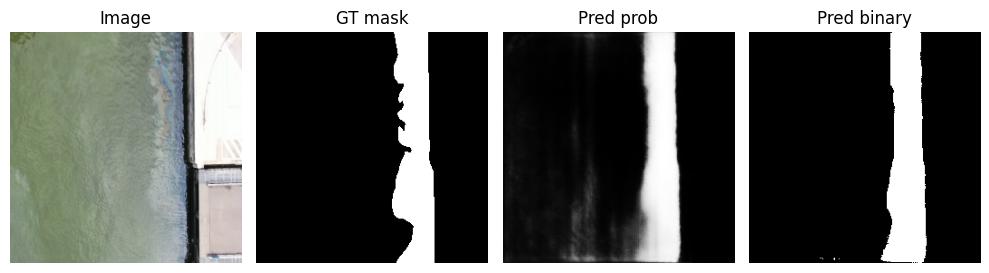

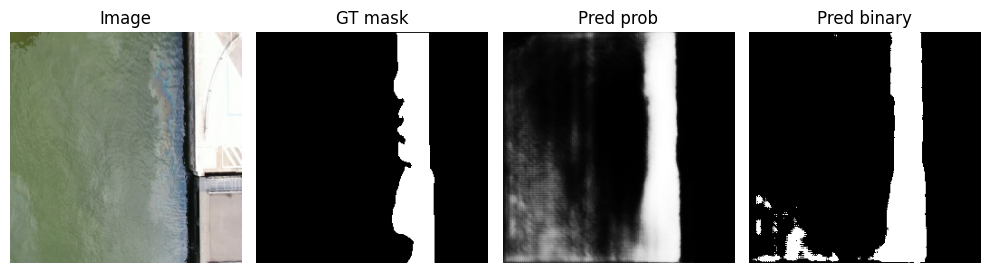

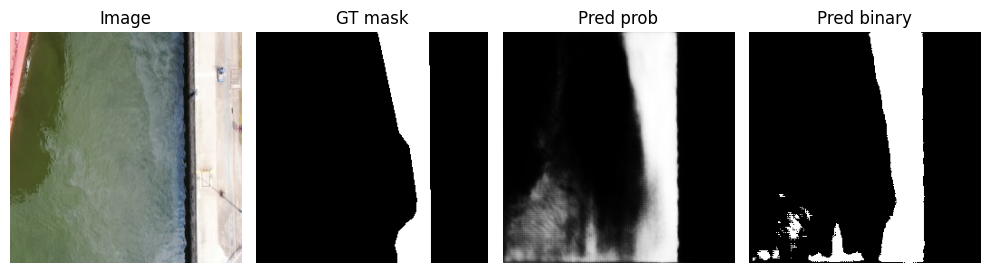

In [ ]:
def show_predictions(dataset, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num):
            img  = images[i].numpy()
            gt   = masks[i].numpy().squeeze()
            pred = preds[i].squeeze()  # FIXED here
            pred_bin = (pred > 0.5).astype(np.float32)

            plt.figure(figsize=(10,3))
            plt.subplot(1,4,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
            plt.subplot(1,4,2); plt.imshow(gt, cmap='gray'); plt.title("GT mask"); plt.axis("off")
            plt.subplot(1,4,3); plt.imshow(pred, cmap='gray'); plt.title("Pred prob"); plt.axis("off")
            plt.subplot(1,4,4); plt.imshow(pred_bin, cmap='gray'); plt.title("Pred binary"); plt.axis("off")
            plt.tight_layout()
            plt.show()

show_predictions(val_ds, num=3)


In [ ]:
model.save("/content/drive/MyDrive/oilspill_results/final_unet.keras")
print("Model saved.")


Model saved.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- custom metrics and loss (same as during training) ---

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_pred_f = tf.cast(y_pred_f > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/oilspill_results/final_unet.keras"

model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        "dice_coef": dice_coef,
        "iou_metric": iou_metric,
        "bce_dice_loss": bce_dice_loss
    }
)

print("Model loaded successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully


Testing image: /content/drive/MyDrive/oilspill_dataset/test/resized_images/Oil (1171).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Oil pixel fraction: 0.068603516
Final Prediction: OIL SPILL PRESENT


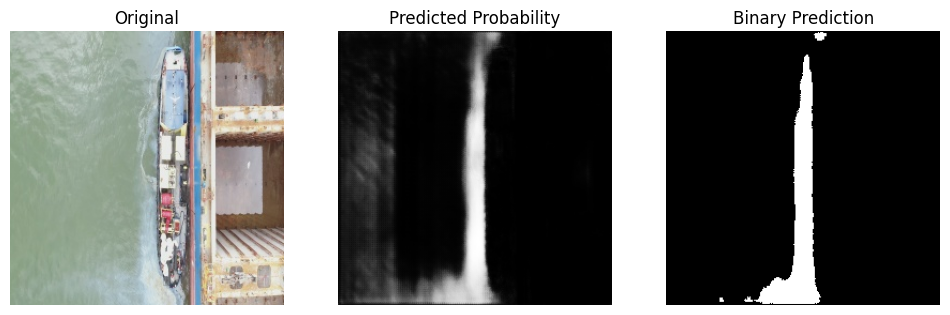

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# dataset root
root = "/content/drive/MyDrive/oilspill_dataset/"
IMG_SIZE = (256, 256)

# pick first test image
test_img_dir = root + "test/resized_images/"
file_list = os.listdir(test_img_dir)

# safety check
if len(file_list) == 0:
    print("No test images found!")
else:
    sample_name = file_list[0]   # choose first image
    sample_path = os.path.join(test_img_dir, sample_name)
    print("Testing image:", sample_path)

    # ---------- PREPROCESS ----------
    img = Image.open(sample_path).convert("RGB")
    img_resized = img.resize(IMG_SIZE)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    inp = np.expand_dims(img_array, axis=0)

    # ---------- PREDICT MASK ----------
    pred = model.predict(inp)[0, :, :, 0]
    pred_prob = pred                          # 0 to 1
    pred_bin = (pred_prob > 0.5).astype(np.float32)  # 0 or 1

    # ---------- CLASSIFICATION ----------
    oil_fraction = pred_bin.mean()
    threshold = 0.001   # 0.1% pixels → detect oil

    print("Oil pixel fraction:", oil_fraction)

    if oil_fraction > threshold:
        print("Final Prediction: OIL SPILL PRESENT")
    else:
        print("Final Prediction: NO OIL SPILL")

    # ---------- VISUALIZE ----------
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(pred_prob, cmap="gray"); plt.title("Predicted Probability"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(pred_bin, cmap="gray"); plt.title("Binary Prediction"); plt.axis("off")
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

os.listdir("/content/drive/MyDrive/")


['Colab Notebooks',
 'AUD-20230926-WA0015.mp3',
 'brand name and tagline by Navyasri.pptx',
 'dbms commands.txt',
 'Future Forge (2).ppt.pptx',
 'Future Forge (1).ppt.pptx',
 'Future Forge.ppt.pptx',
 'Future Forge.ppt (1).pptx',
 'Future Forge.ppt .pptx',
 'Future Forge.ppt .gslides',
 'Final song.mp3',
 'Student_Consent_Letter[1].docx',
 'Student_Consent_Letter[1]-1.docx',
 'CLUB WALTZ 28.mp3',
 'Y23CM011 (9).docx',
 'Y23CM011 (8).docx',
 'Y23CM011 (7).docx',
 'SWARNA ANDHRA.pdf',
 'scott.txt',
 'scott (3).gdoc',
 'scott (2).gdoc',
 'scott2 (1).txt',
 'scott2.txt',
 'scott2 (1).gdoc',
 'scott (1).gdoc',
 'scott2.gdoc',
 'scott.gdoc',
 'scott database.txt',
 'scott database.gdoc',
 'Y23CM011 (6).docx',
 'Y23CM011 (5).docx',
 'Y23CM011 (4).docx',
 'Y23CM011 (3).docx',
 'Untitled presentation (7).gslides',
 'New Microsoft PowerPoint Presentation 2.pptx',
 'Y23CM011 (1).docx',
 'Dtpi.gslides',
 'unknown',
 'Y23CM011.docx',
 'Y23CM011 (2).docx',
 'SCINTILLA.pdf',
 'SCINTILLA.gdoc',
 'Plac

In [ ]:
os.listdir("/content/drive/MyDrive/oilspill_results/")


['best_unet.keras', 'final_unet.keras']

In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/oilspill_results/best_unet.keras",
    custom_objects={
        "dice_coef": dice_coef,
        "iou_metric": iou_metric,
        "bce_dice_loss": bce_dice_loss
    }
)

print("Model loaded successfully")


Model loaded successfully


In [ ]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_pred_f = tf.cast(y_pred_f > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

IMG_DIR  = "/content/drive/MyDrive/oilspill_dataset/test/resized_images/"
MASK_DIR = "/content/drive/MyDrive/oilspill_dataset/test/resized_masks/"

img_name = os.listdir(IMG_DIR)[0]

image = np.array(Image.open(os.path.join(IMG_DIR, img_name)).convert("RGB")) / 255.0
mask  = np.array(Image.open(os.path.join(MASK_DIR, img_name.replace(".jpg",".png")))) / 255.0


In [ ]:
pred = model.predict(np.expand_dims(image, 0))[0].squeeze()
pred_binary = (pred > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


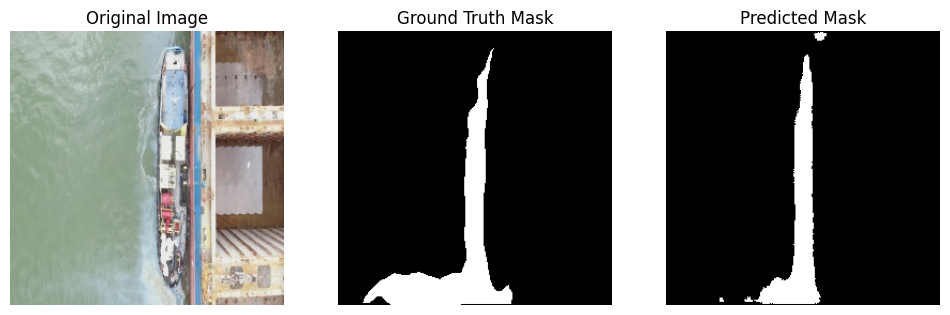

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_binary, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


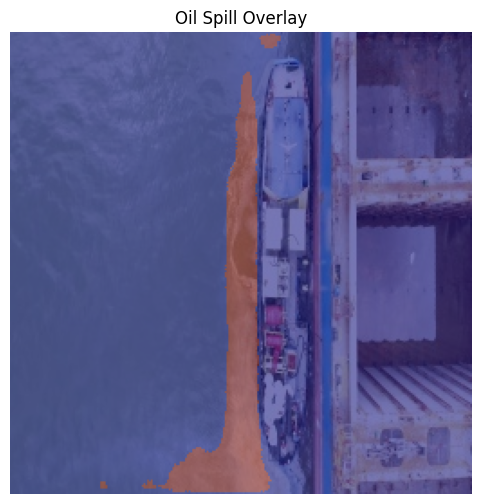

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.imshow(pred_binary, cmap="jet", alpha=0.5)
plt.title("Oil Spill Overlay")
plt.axis("off")
plt.show()


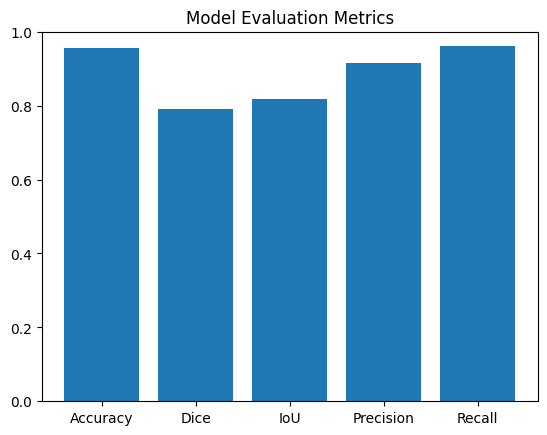

In [ ]:
metrics = {
    "Accuracy": 0.9545,
    "Dice": 0.792,
    "IoU": 0.819,
    "Precision": 0.914,
    "Recall": 0.962
}

plt.bar(metrics.keys(), metrics.values())
plt.ylim(0,1)
plt.title("Model Evaluation Metrics")
plt.show()
